# Results Analysis - DreamBooth vs LoRA vs Textual Inversion vs Baseline (FINAL)

Phân tích kết quả using final CLIP-based metrics:
- **CLIP-content** (main)
- **Style Strength Score** (CLIP-content / baseline)
- **CLIP-style** (main)



## Setup


In [9]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RESULTS_DIR = Path("/kaggle/working/results/metrics")
if not RESULTS_DIR.exists():
    RESULTS_DIR = Path(r"D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics")

METRICS_FILE = RESULTS_DIR / "all_metrics_final.csv"
METRICS_JSON = RESULTS_DIR / "all_metrics_final.json"

print(f"Results directory: {RESULTS_DIR}")
print(f"Metrics CSV exists: {METRICS_FILE.exists()}")
print(f"Metrics JSON exists: {METRICS_JSON.exists()}")


Results directory: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics
Metrics CSV exists: True
Metrics JSON exists: True


## Merge Metrics Files


In [10]:
LORA_METRICS_CSV = RESULTS_DIR / "lora_metrics_final.csv"
LORA_METRICS_JSON = RESULTS_DIR / "lora_metrics_final.json"
DREAMBOOTH_TI_METRICS_CSV = RESULTS_DIR / "dreambooth_ti_metrics_final.csv"
DREAMBOOTH_TI_METRICS_JSON = RESULTS_DIR / "dreambooth_ti_metrics_final.json"

required_cols = ["model", "clip_content", "clip_content_std", "style_strength"]

if LORA_METRICS_JSON.exists() and DREAMBOOTH_TI_METRICS_JSON.exists():
    print("Merging FINAL metrics files...")
    
    with open(LORA_METRICS_JSON, 'r', encoding='utf-8') as f:
        metrics_lora = json.load(f)
    with open(DREAMBOOTH_TI_METRICS_JSON, 'r', encoding='utf-8') as f:
        metrics_db_ti = json.load(f)
    
    df_lora = pd.DataFrame(metrics_lora).T
    df_lora.index.name = "model"
    df_lora = df_lora.reset_index()
    
    df_db_ti = pd.DataFrame(metrics_db_ti).T
    df_db_ti.index.name = "model"
    df_db_ti = df_db_ti.reset_index()
    
    for col in required_cols:
        if col not in df_lora.columns:
            raise ValueError(f"LoRA metrics missing column: {col}")
        if col not in df_db_ti.columns:
            raise ValueError(f"DreamBooth metrics missing column: {col}")
    
    baseline_lora = df_lora[df_lora['model'] == 'baseline']
    baseline_db_ti = df_db_ti[df_db_ti['model'] == 'baseline']
    
    other_lora = df_lora[df_lora['model'] != 'baseline']
    other_db_ti = df_db_ti[df_db_ti['model'] != 'baseline']
    
    baseline_dict = {
        'model': 'baseline',
        'clip_content': (baseline_lora['clip_content'].values[0] + baseline_db_ti['clip_content'].values[0]) / 2,
        'clip_content_std': (baseline_lora['clip_content_std'].values[0] + baseline_db_ti['clip_content_std'].values[0]) / 2,
        'style_strength': 1.0,
    }
    
    if 'clip_style' in df_lora.columns or 'clip_style' in df_db_ti.columns:
        baseline_dict['clip_style'] = np.nan
        baseline_dict['clip_style_std'] = np.nan
    
    baseline_avg = pd.DataFrame([baseline_dict])
    
    df_merged = pd.concat([baseline_avg, other_lora, other_db_ti], ignore_index=True)
    df_merged.to_csv(METRICS_FILE, index=False)
    print(f"Saved merged CSV: {METRICS_FILE}")
    print(f"Total models: {len(df_merged)}")
    
    merged_json = {}
    merged_json['baseline'] = {
        'clip_content': baseline_dict['clip_content'],
        'clip_content_std': baseline_dict['clip_content_std'],
        'style_strength': 1.0,
    }
    if 'clip_style' in df_lora.columns or 'clip_style' in df_db_ti.columns:
        merged_json['baseline']['clip_style'] = np.nan
        merged_json['baseline']['clip_style_std'] = np.nan
    
    for key, value in metrics_lora.items():
        if key != 'baseline':
            merged_json[key] = value
    for key, value in metrics_db_ti.items():
        if key != 'baseline':
            merged_json[key] = value
    
    with open(METRICS_JSON, 'w', encoding='utf-8') as f:
        json.dump(merged_json, f, indent=2)
    print(f"Saved merged JSON: {METRICS_JSON}")
    
    print("\nMerged metrics preview:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 25)
    print(df_merged.to_string(index=False))
    
    print(f"\nFull metrics table saved to: {METRICS_FILE}")
elif METRICS_FILE.exists():
    print(f"Using existing merged file: {METRICS_FILE}")
else:
    print("Warning: Could not find final metrics JSON files")
    print("Please run 04a_Evaluation_Metrics_LoRA_FINAL.ipynb and 04b_Evaluation_Metrics_DreamBooth_TI_FINAL.ipynb first")


Merging FINAL metrics files...
Saved merged CSV: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\all_metrics_final.csv
Total models: 9
Saved merged JSON: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\all_metrics_final.json

Merged metrics preview:
                         model  clip_content  clip_content_std  style_strength  clip_style  clip_style_std
                      baseline      0.408875          0.051892        1.000000         NaN             NaN
           lora_actionpainting      0.415344          0.063845        1.015823    0.342773        0.074377
         lora_analyticalcubism      0.429932          0.064783        1.051500    0.354980        0.085261
      lora_contemporaryrealism      0.426117          0.062351        1.042170    0.438843        0.047444
               lora_newrealism      0.419769          0.072526        1.026646    0.439026        0.054232
          lora_syntheticcubism      0.429688          0.062362        1.050903    0.329285        0.060667
dre

## Load Metrics


In [11]:
if METRICS_FILE.exists():
    df = pd.read_csv(METRICS_FILE)
    print("Loaded from CSV")
elif METRICS_JSON.exists():
    with open(METRICS_JSON, 'r', encoding='utf-8') as f:
        metrics_dict = json.load(f)
    df = pd.DataFrame(metrics_dict).T
    df.index.name = "model"
    df = df.reset_index()
    print("Loaded from JSON")
else:
    print("No metrics file found. Please run merge cell above first.")
    df = None

if df is not None:
    required_cols_display = ['clip_content', 'style_strength']
    for col in required_cols_display:
        if col not in df.columns:
            raise ValueError(f"Metrics missing column: {col}")
    
    print(f"\nShape: {df.shape}")
    print(f"Models: {df['model'].tolist()}")
    print(f"\nColumns: {list(df.columns)}")
    
    print("\n" + "="*80)
    print("FULL METRICS TABLE (FINAL)")
    print("="*80)
    
    display_cols = ['model', 'clip_content', 'style_strength']
    if 'clip_style' in df.columns:
        display_cols.append('clip_style')
    
    display_df = df[display_cols].copy()
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 30)
    
    formatted_df = display_df.copy()
    formatted_df['clip_content'] = formatted_df['clip_content'].apply(lambda x: f"{x:.4f}")
    formatted_df['style_strength'] = formatted_df['style_strength'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    if 'clip_style' in formatted_df.columns:
        formatted_df['clip_style'] = formatted_df['clip_style'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    print(formatted_df.to_string(index=False))
    print("\n" + "="*80)
    
    def _extract_style_key(name: str) -> str:
        lowered = name.lower()
        if lowered == 'baseline':
            return 'baseline'
        return re.sub(r'^(dreambooth_|lora_|ti_|textualinversion_|textual_)', '', lowered)
    
    df['style_key'] = df['model'].apply(_extract_style_key)
    lora_styles = set(df[df['model'].str.contains('lora_', case=False, na=False)]['style_key'])
    dream_styles = set(df[df['model'].str.contains('dreambooth_', case=False, na=False)]['style_key'])
    shared_styles = sorted(list(lora_styles & dream_styles))
    
    if shared_styles:
        baseline_rows = df[df['model'] == 'baseline']
        non_baseline = df[df['model'] != 'baseline']
        ti_rows = non_baseline[non_baseline['model'].str.contains('ti_', case=False, na=False) | non_baseline['model'].str.contains('textual', case=False, na=False)]
        shared_rows = non_baseline[non_baseline['style_key'].isin(shared_styles)]
        filtered_rows = pd.concat([shared_rows, ti_rows]).drop_duplicates(subset=['model'])
        removed = len(non_baseline) - len(filtered_rows)
        df = pd.concat([baseline_rows, filtered_rows], ignore_index=True)
        print(f"\nApplying shared-style filter (LoRA ∩ DreamBooth): {shared_styles}")
        print(f"Keeping all Textual Inversion entries.")
        print(f"Removed {removed} entries that do not have a shared style (excluding TI).")
        filtered_display = df[['model', 'clip_content', 'style_strength']].copy()
        if 'clip_style' in df.columns:
            filtered_display['clip_style'] = df['clip_style']
        filtered_display['clip_content'] = filtered_display['clip_content'].apply(lambda x: f"{x:.4f}")
        filtered_display['style_strength'] = filtered_display['style_strength'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        if 'clip_style' in filtered_display.columns:
            filtered_display['clip_style'] = filtered_display['clip_style'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print("\n" + "="*80)
        print("FILTERED METRICS TABLE (SHARED STYLES + TI)")
        print("="*80)
        print(filtered_display.to_string(index=False))
        print("\n" + "="*80)
    else:
        print("\nNo shared styles between LoRA và DreamBooth were found; keeping all models.")


Loaded from CSV

Shape: (9, 6)
Models: ['baseline', 'lora_actionpainting', 'lora_analyticalcubism', 'lora_contemporaryrealism', 'lora_newrealism', 'lora_syntheticcubism', 'dreambooth_contemporaryrealism', 'dreambooth_newrealism', 'ti_sksstyle']

Columns: ['model', 'clip_content', 'clip_content_std', 'style_strength', 'clip_style', 'clip_style_std']

FULL METRICS TABLE (FINAL)
                         model clip_content style_strength clip_style
                      baseline       0.4089         1.0000        N/A
           lora_actionpainting       0.4153         1.0158     0.3428
         lora_analyticalcubism       0.4299         1.0515     0.3550
      lora_contemporaryrealism       0.4261         1.0422     0.4388
               lora_newrealism       0.4198         1.0266     0.4390
          lora_syntheticcubism       0.4297         1.0509     0.3293
dreambooth_contemporaryrealism       0.4321         1.0567     0.4327
         dreambooth_newrealism       0.4442         1.0865   

## Visualization - Metrics Comparison


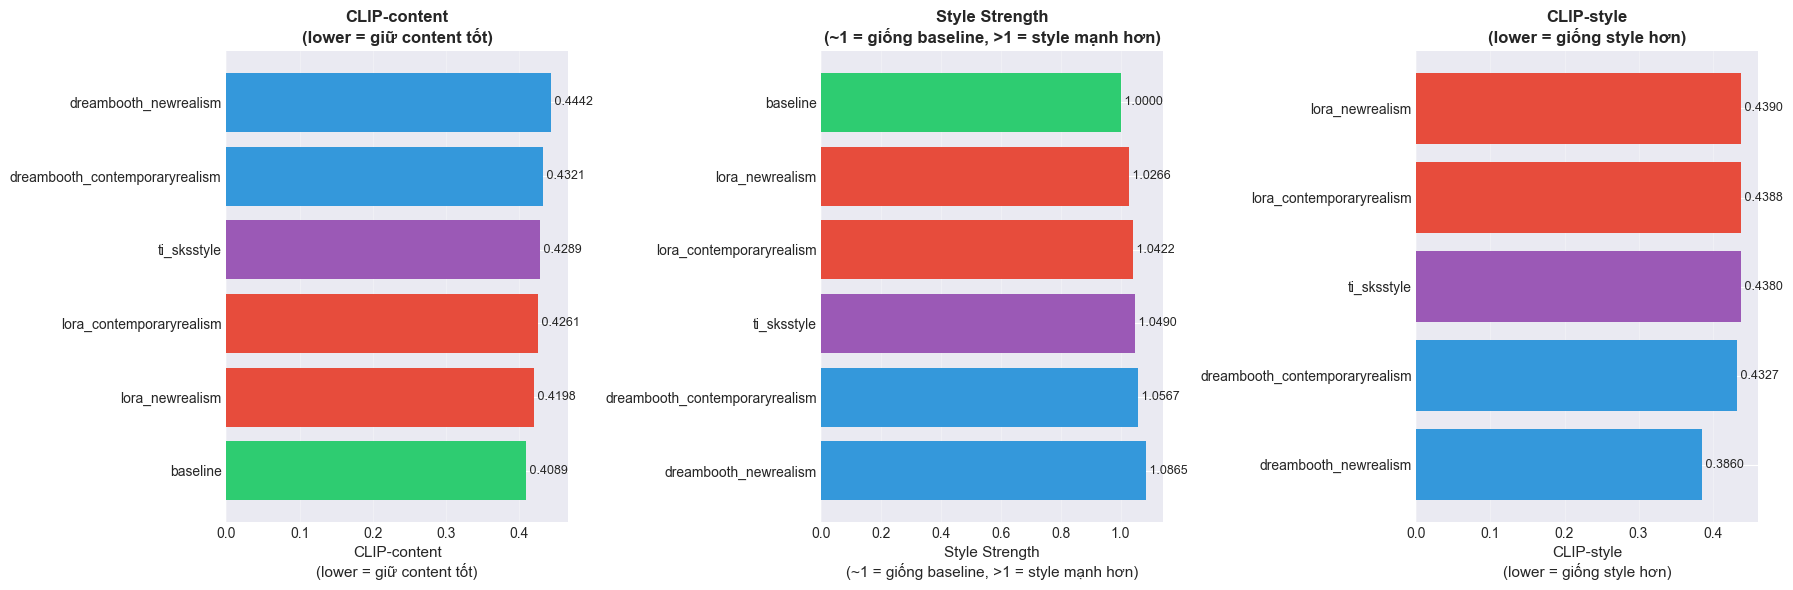

Saved: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\metrics_comparison_final.png


In [12]:
if df is not None:
    has_style_metrics = 'clip_style' in df.columns and df['clip_style'].notna().any()
    
    metrics_to_plot = [
        ('clip_content', 'CLIP-content\n(lower = giữ content tốt)', True),
        ('style_strength', 'Style Strength\n(~1 = giống baseline, >1 = style mạnh hơn)', False),
    ]
    
    if has_style_metrics:
        metrics_to_plot.append(('clip_style', 'CLIP-style\n(lower = giống style hơn)', True))
    
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(6 * len(metrics_to_plot), 6))
    if len(metrics_to_plot) == 1:
        axes = [axes]
    
    for idx, (metric, title, ascending) in enumerate(metrics_to_plot):
        ax = axes[idx]
        data = df[['model', metric]].dropna(subset=[metric]).sort_values(metric, ascending=ascending)
        if len(data) == 0:
            continue
        colors = ['#2ecc71' if 'baseline' in m.lower() 
                 else '#3498db' if 'dreambooth' in m.lower() 
                 else '#9b59b6' if 'ti_' in m.lower() or 'textual' in m.lower()
                 else '#e74c3c' 
                 for m in data['model']]
        bars = ax.barh(data['model'], data[metric], color=colors)
        ax.set_xlabel(title, fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, data[metric])):
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "metrics_comparison_final.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {RESULTS_DIR / 'metrics_comparison_final.png'}")


## Model Type Comparison


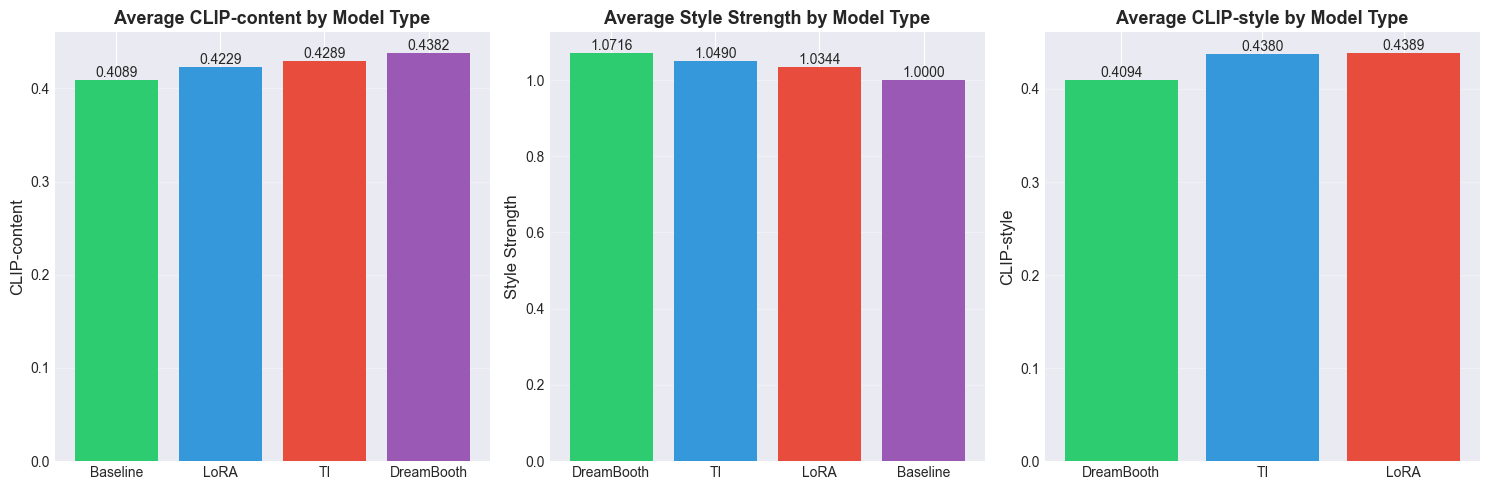

Saved: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\model_type_comparison_final.png


In [13]:
if df is not None:
    df['model_type'] = df['model'].apply(lambda x: 
        'Baseline' if 'baseline' in x.lower() 
        else 'DreamBooth' if 'dreambooth' in x.lower() 
        else 'LoRA' if 'lora' in x.lower() 
        else 'TI' if 'ti_' in x.lower() or 'textual' in x.lower() 
        else 'Other')
    
    metrics_config = [
        ('clip_content', 'CLIP-content', True),
        ('style_strength', 'Style Strength', False),
    ]
    if 'clip_style' in df.columns and df['clip_style'].notna().any():
        metrics_config.append(('clip_style', 'CLIP-style', True))
    
    fig, axes = plt.subplots(1, len(metrics_config), figsize=(5 * len(metrics_config), 5))
    if len(metrics_config) == 1:
        axes = [axes]
    
    for idx, (metric, name, ascending) in enumerate(metrics_config):
        ax = axes[idx]
        model_type_data = df.groupby('model_type')[metric].mean()
        model_type_data = model_type_data.dropna().sort_values(ascending=ascending)
        if len(model_type_data) == 0:
            continue
        bars = ax.bar(model_type_data.index, model_type_data.values, 
                     color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12'][:len(model_type_data)])
        ax.set_ylabel(name, fontsize=12)
        ax.set_title(f'Average {name} by Model Type', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        for bar, val in zip(bars, model_type_data.values):
            ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "model_type_comparison_final.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {RESULTS_DIR / 'model_type_comparison_final.png'}")


## Comparison with Baseline


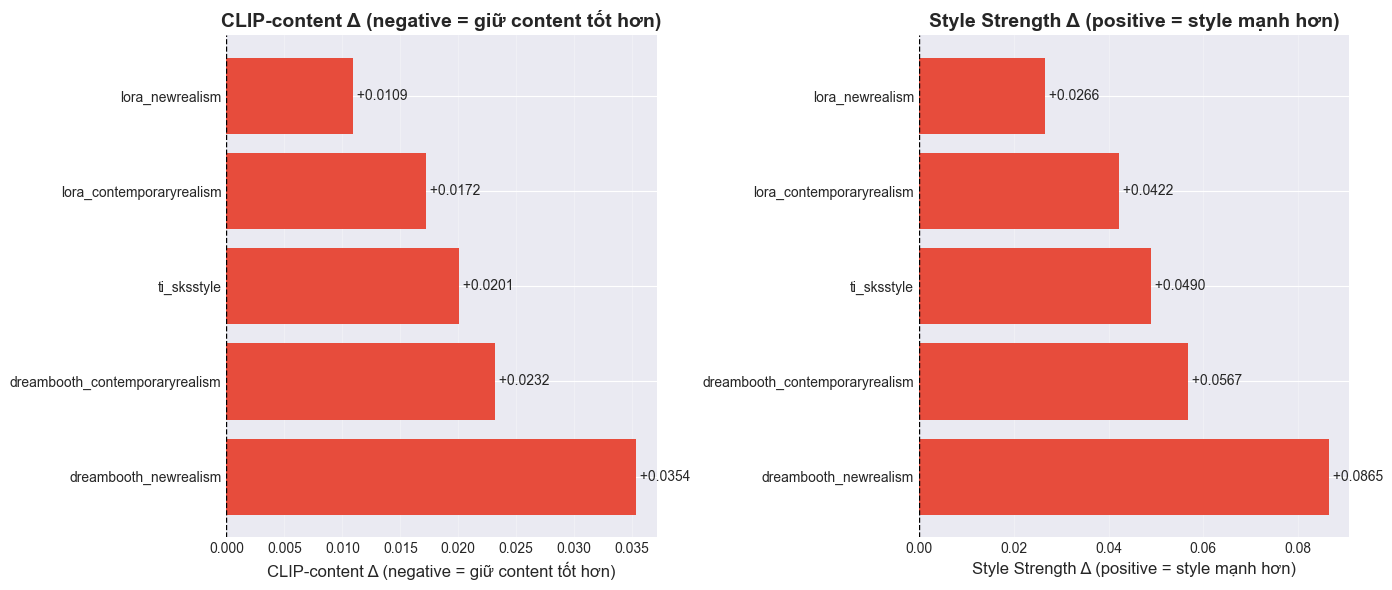

Saved: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\baseline_comparison_final.png

IMPROVEMENT SUMMARY (FINAL)

                         model clip_delta style_strength clip_style
      lora_contemporaryrealism    +0.0172         1.0422     0.4388
               lora_newrealism    +0.0109         1.0266     0.4390
dreambooth_contemporaryrealism    +0.0232         1.0567     0.4327
         dreambooth_newrealism    +0.0354         1.0865     0.3860
                   ti_sksstyle    +0.0201         1.0490     0.4380


In [14]:
if df is not None:
    baseline_row = df[df['model'] == 'baseline']
    
    if not baseline_row.empty:
        baseline_clip = baseline_row['clip_content'].values[0]
        other_models = df[df['model'] != 'baseline'].copy()
        other_models['clip_delta'] = other_models['clip_content'] - baseline_clip
        other_models['style_strength_adjusted'] = other_models['style_strength'] - 1.0
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        plots = [
            ('clip_delta', 'CLIP-content Δ (negative = giữ content tốt hơn)', True),
            ('style_strength_adjusted', 'Style Strength Δ (positive = style mạnh hơn)', True),
        ]
        
        for idx, (metric, title, positive_is_good) in enumerate(plots):
            ax = axes[idx]
            data = other_models.sort_values(metric, ascending=not positive_is_good)
            colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in data[metric]]
            bars = ax.barh(data['model'], data[metric], color=colors)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
            ax.set_xlabel(title, fontsize=12)
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            for i, (bar, val) in enumerate(zip(bars, data[metric])):
                ax.text(val, i, f' {val:+.4f}', va='center', fontsize=10)
        
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "baseline_comparison_final.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {RESULTS_DIR / 'baseline_comparison_final.png'}")
        
        print("\n" + "="*80)
        print("IMPROVEMENT SUMMARY (FINAL)")
        print("="*80)
        summary_df = other_models[['model', 'clip_delta', 'style_strength']].copy()
        summary_df['clip_delta'] = summary_df['clip_delta'].apply(lambda x: f"{x:+.4f}")
        summary_df['style_strength'] = summary_df['style_strength'].apply(lambda x: f"{x:.4f}")
        if 'clip_style' in other_models.columns:
            summary_df['clip_style'] = other_models['clip_style'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        print("\n" + summary_df.to_string(index=False))


## Style Analysis


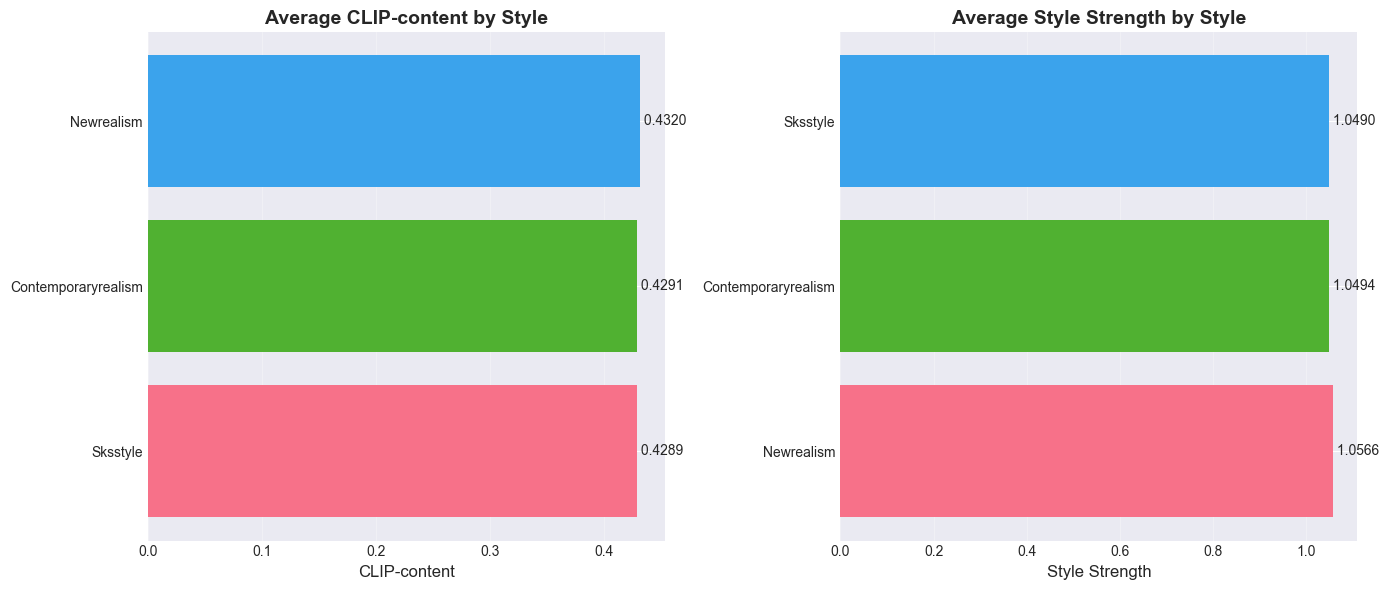

Saved: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\style_analysis_final.png


In [15]:
if df is not None:
    df['style'] = df['model'].apply(lambda x: 
        x.replace('dreambooth_', '').replace('lora_', '').replace('ti_', '').replace('_', ' ').title())
    styles = df[df['model'] != 'baseline']['style'].unique()
    if len(styles) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        metrics = [('clip_content', True), ('style_strength', False)]
        for idx, (metric, ascending) in enumerate(metrics):
            ax = axes[idx]
            style_data = []
            for style in styles:
                style_models = df[df['style'] == style]
                if not style_models.empty:
                    avg_val = style_models[metric].mean()
                    style_data.append({'style': style, metric: avg_val})
            if style_data:
                style_df = pd.DataFrame(style_data).sort_values(metric, ascending=ascending)
                bars = ax.barh(style_df['style'], style_df[metric], color=sns.color_palette("husl", len(style_df)))
                label = 'CLIP-content' if metric == 'clip_content' else 'Style Strength'
                ax.set_xlabel(label, fontsize=12)
                ax.set_title(f'Average {label} by Style', fontsize=14, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                for bar, val in zip(bars, style_df[metric]):
                    ax.text(val, bar.get_y() + bar.get_height()/2, f' {val:.4f}', va='center', fontsize=10)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "style_analysis_final.png", dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: {RESULTS_DIR / 'style_analysis_final.png'}")


## Summary Report


In [16]:
if df is not None:
    print("="*80)
    print("RESULTS SUMMARY REPORT (FINAL)")
    print("="*80)
    
    baseline_row = df[df['model'] == 'baseline']
    if not baseline_row.empty:
        print(f"\nBaseline (SD v1.5 img2img):")
        print(f"  CLIP-content: {baseline_row['clip_content'].values[0]:.4f}")
        print(f"  Style Strength: {baseline_row['style_strength'].values[0]:.4f}")
    
    other_models = df[df['model'] != 'baseline']
    has_style_metrics = 'clip_style' in df.columns and df['clip_style'].notna().any()
    
    if not other_models.empty:
        print(f"\n{'='*80}")
        print("BEST MODELS")
        print(f"{'='*80}")
        
        best_clip = other_models.loc[other_models['clip_content'].idxmin()]
        print(f"\nContent Preservation:")
        print(f"  Thấp nhất CLIP-content: {best_clip['model']} ({best_clip['clip_content']:.4f})")
        
        strongest_style = other_models.loc[other_models['style_strength'].idxmax()]
        print(f"  Style mạnh nhất (Style Strength): {strongest_style['model']} ({strongest_style['style_strength']:.4f})")
        
        if has_style_metrics:
            best_style = other_models.loc[other_models['clip_style'].idxmin()]
            print(f"\nStyle Quality:")
            print(f"  Thấp nhất CLIP-style: {best_style['model']} ({best_style['clip_style']:.4f})")
        
        print(f"\n{'='*80}")
        print("MODEL TYPE PERFORMANCE")
        print(f"{'='*80}")
        
        agg_dict = {
            'clip_content': 'mean',
            'style_strength': 'mean'
        }
        if has_style_metrics:
            agg_dict['clip_style'] = 'mean'
        
        model_type_stats = other_models.groupby('model_type').agg(agg_dict)
        
        for model_type, row in model_type_stats.iterrows():
            print(f"\n{model_type}:")
            print(f"  Avg CLIP-content: {row['clip_content']:.4f}")
            print(f"  Avg Style Strength: {row['style_strength']:.4f}")
            if has_style_metrics and 'clip_style' in row:
                print(f"  Avg CLIP-style: {row['clip_style']:.4f}")
    
    print("\n" + "="*80)
    
    summary_path = RESULTS_DIR / "summary_report_final.txt"
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESULTS SUMMARY REPORT (FINAL)\n")
        f.write("="*80 + "\n")
        if not baseline_row.empty:
            f.write(f"\nBaseline (SD v1.5 img2img):\n")
            f.write(f"  CLIP-content: {baseline_row['clip_content'].values[0]:.4f}\n")
            f.write(f"  Style Strength: {baseline_row['style_strength'].values[0]:.4f}\n")
        if not other_models.empty:
            f.write(f"\nBest Models:\n")
            f.write(f"  Thấp nhất CLIP-content: {best_clip['model']} ({best_clip['clip_content']:.4f})\n")
            f.write(f"  Style mạnh nhất: {strongest_style['model']} ({strongest_style['style_strength']:.4f})\n")
            if has_style_metrics:
                f.write(f"  Thấp nhất CLIP-style: {best_style['model']} ({best_style['clip_style']:.4f})\n")
    
    print(f"Summary report saved to: {summary_path}")


RESULTS SUMMARY REPORT (FINAL)

Baseline (SD v1.5 img2img):
  CLIP-content: 0.4089
  Style Strength: 1.0000

BEST MODELS

Content Preservation:
  Thấp nhất CLIP-content: lora_newrealism (0.4198)
  Style mạnh nhất (Style Strength): dreambooth_newrealism (1.0865)

Style Quality:
  Thấp nhất CLIP-style: dreambooth_newrealism (0.3860)

MODEL TYPE PERFORMANCE

DreamBooth:
  Avg CLIP-content: 0.4382
  Avg Style Strength: 1.0716
  Avg CLIP-style: 0.4094

LoRA:
  Avg CLIP-content: 0.4229
  Avg Style Strength: 1.0344
  Avg CLIP-style: 0.4389

TI:
  Avg CLIP-content: 0.4289
  Avg Style Strength: 1.0490
  Avg CLIP-style: 0.4380

Summary report saved to: D:\HK5\CS431-KiThuaHocSau\DoAn\results\metrics\summary_report_final.txt
